In [2]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
from numpy import pi


from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler

from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit import Parameter

In [4]:
def apply_trotter_steps(qc, ZZZ, ZX, steps):
    for _ in range(steps):
        qc.append(ZZZ, [0, 1, 2])
        qc.append(ZX,  [0, 3])
        qc.append(ZX,  [1, 4])

In [6]:
steps=2

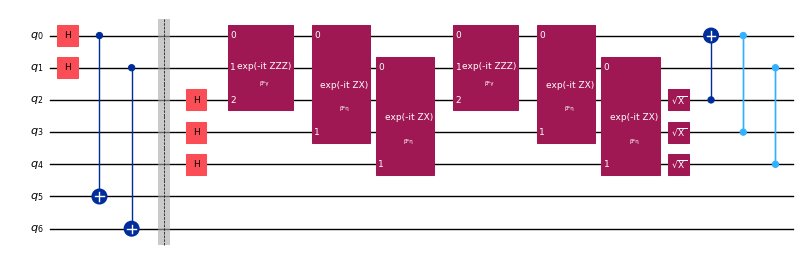

In [8]:
γ = Parameter('γ')
η = Parameter('η')
β = Parameter('β')

X = SparsePauliOp("X")
Z = SparsePauliOp("Z")

qc_sym = QuantumCircuit(7)

qc_sym.h([0,1])
qc_sym.cx(0,5)
qc_sym.cx(1,6)
qc_sym.barrier()

ZZZ = PauliEvolutionGate(Z^Z^Z, time=β*γ)
ZX = PauliEvolutionGate(Z^X, time=β*η)

qc_sym.h([2,3,4])

apply_trotter_steps(qc_sym, ZZZ, ZX, steps)

qc_sym.sx([2,3,4])

qc_sym.cx(2,0)
qc_sym.cz(3,0)
qc_sym.cz(4,1)

qc_sym.draw("mpl",scale=0.5, fold=100)

In [9]:
sim = AerSimulator(method="statevector")

In [10]:
H_sym = SparsePauliOp(["IIIIIZZ","IIIIIXI","IIIIIIX"], coeffs=[γ,η,η])

In [11]:
H = H_sym.assign_parameters({γ:pi/4,η:pi/4})
H = SparsePauliOp(H.paulis, coeffs=np.asarray(H.coeffs, dtype=np.complex128)) #Forcing correct assignment

qc = qc_sym.assign_parameters({γ:pi/4,η:pi/4,β:-0.35})

In [12]:
pm = generate_preset_pass_manager(backend=sim, optimization_level=3)
isa_qc = pm.run(qc)
isa_H = H.apply_layout(isa_qc.layout)

/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


In [13]:
estimator = Estimator(mode=sim, options={"default_shots": 10000})

In [20]:
res = estimator.run([(isa_qc, isa_H)]).result()[0]
print(f"Expectation values: {res.data.evs}")

Expectation values: -1.61587818137391


In [22]:
from qiskit.circuit.library import phase_estimation, PauliEvolutionGate

In [68]:
bits = 3
t = 4/3

In [70]:
from qiskit.synthesis import LieTrotter

In [72]:
H_qpe = SparsePauliOp(["ZZ","XI","IX"], coeffs=[γ,η,η]).assign_parameters({γ:pi/4,η:pi/4})
H_qpe = SparsePauliOp(H_qpe.paulis, coeffs=np.asarray(H_qpe.coeffs, dtype=np.complex128))

evo = PauliEvolutionGate(H_qpe, time=-t,synthesis=LieTrotter(reps=8))  
 
qpe = phase_estimation(bits, evo)

In [74]:
qc_qpe = QuantumCircuit(7+bits)

qc_qpe.append(qc_sym.assign_parameters({γ:pi/4,η:pi/4,β:-0.35}), [0,1,2,3,4,5,6])

qc_qpe.barrier()

qc_qpe.append(qpe, [j for j in range(7, 7+bits)]+[0,1])

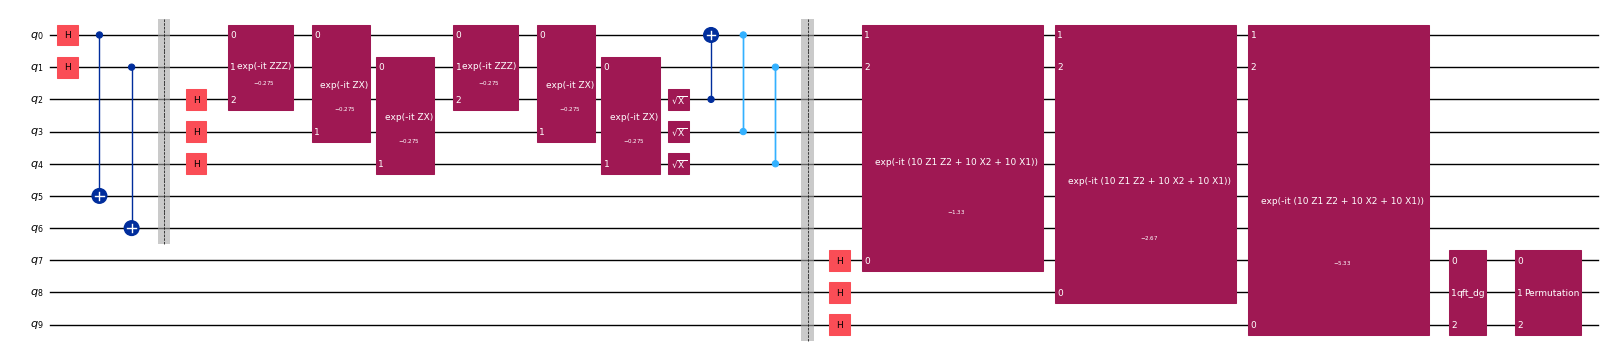

In [76]:
qc_qpe.decompose().draw("mpl",scale=0.5, fold=100)

In [78]:
qc_meas = qc_qpe.copy()

c_qpe = ClassicalRegister(bits, "c_qpe")
qc_meas.add_register(c_qpe)

for j in range(bits):
    qc_meas.measure(7 + j, c_qpe[bits - 1 - j])
    
sampler = Sampler()

job = sampler.run(qc_meas, shots=1000)
result = job.result()

quasi_dist = result.quasi_dists[0]

counts = {
    format(k, f'0{bits}b'): round(v * 1000)
    for k, v in quasi_dist.items()
}

print(counts)

{'000': 8, '110': 46, '001': 5, '100': 12, '011': 13, '111': 91, '101': 825}


In [80]:
max_bitstring = max(counts, key=counts.get)
max_counts = counts[max_bitstring]

In [82]:
def decode_energy(bitstring, t):
    n = len(bitstring)
    j = int(bitstring, 2)
    phi=j/2**n
    phi = np.asarray(phi)
    
    # unwrap
    phi_unwrapped = np.where(phi < 0.5, phi, phi - 1.0)
    
    # convert to energy
    E = 2*pi* phi_unwrapped / (t)
    
    return E

In [84]:
energy = decode_energy(max_bitstring, t) 
print(f"bitstring = {max_bitstring},  E = {energy:.6f}")

bitstring = 101,  E = -1.767146


In [86]:
for key, value in counts.items():
    energy = decode_energy(key, t) 
    print(f"key = {key}, value = {value}, E = {energy:.6f}")

NameError: name 'a' is not defined